In [2]:
import scipy.io

# Load the MATLAB file
data_path = 'pedestrian.mat'
mat_contents = scipy.io.loadmat(data_path)

# Extract the data for marg1A sensor
marg1A_data = mat_contents['marg1A']

# Display the shape of the data to understand its structure
marg1A_data.shape


(10, 494)

In [5]:
fs = 100  # Sampling frequency (Hz)
t = np.linspace(0, 10, fs*10)  # 10 seconds of data
step_frequency = 2  # Steps per second
synthetic_acc = 9.81 * 0.5 * np.sin(2 * np.pi * step_frequency * t)  # Simulate steps with acceleration

# Preprocessing: Apply low-pass filter to accelerometer data to remove high frequency noise
def low_pass_filter(data, cutoff=3, fs=100, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = filtfilt(b, a, data)
    return filtered_data

acc_filtered = low_pass_filter(synthetic_acc)

# Step Detection: Detect peaks in the filtered accelerometer data
peaks, _ = find_peaks(acc_filtered, height=np.mean(acc_filtered))

# Acceleration Integration to estimate displacement for each detected step
def integrate_acceleration(acc_data, sampling_rate):
    # Integrate acceleration to get velocity
    velocity = np.cumsum(acc_data) / sampling_rate
    # Integrate velocity to get displacement
    displacement = np.cumsum(velocity) / sampling_rate
    return displacement

# Estimate displacement for each step
displacements = []
window_size = fs // step_frequency  # Assume a window around each peak representing a step
for peak in peaks:
    start = max(0, peak - window_size // 2)
    end = min(len(acc_filtered), peak + window_size // 2)
    step_displacement = integrate_acceleration(acc_filtered[start:end] - np.mean(acc_filtered[start:end]), fs)
    displacements.append(step_displacement[-1])  # Get the final displacement for the step

# Calculate average step length from displacements
average_step_length = np.mean(np.abs(displacements))


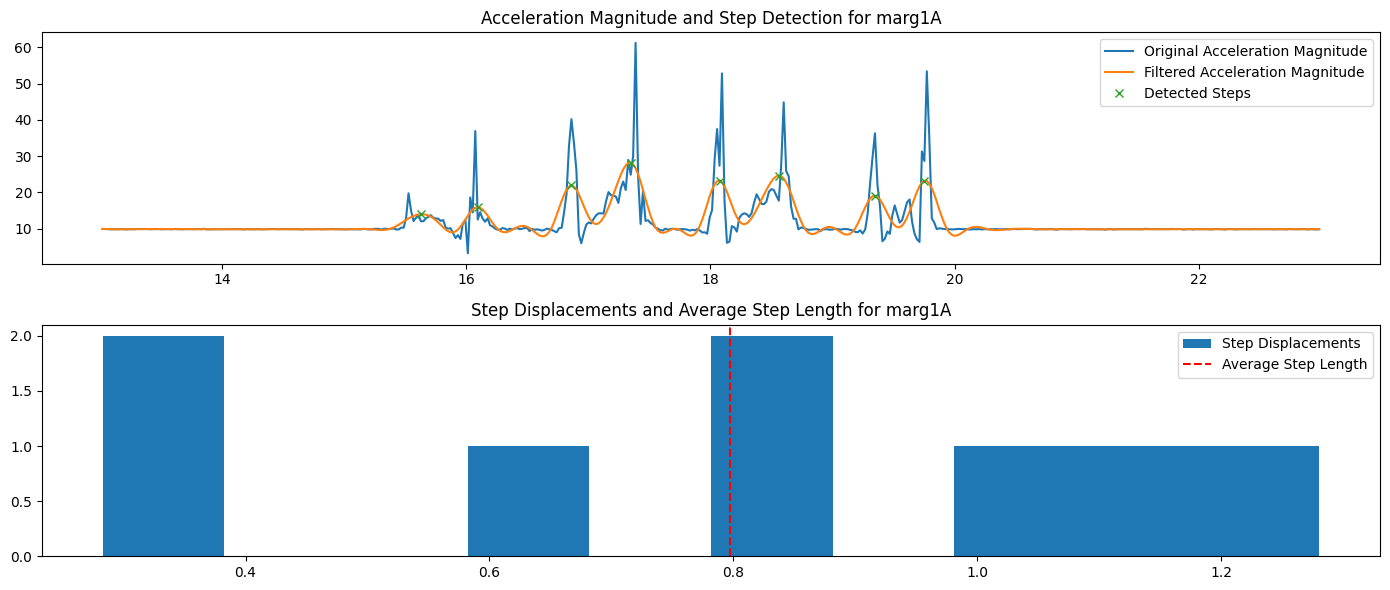

Average Step length: 0.797479408815487


In [7]:
import numpy as np
from scipy.signal import find_peaks, butter, filtfilt
import matplotlib.pyplot as plt
# Extract accelerometer data from marg1A sensor
acc_data_marg1A = marg1A_data[1:4, :]  # Rows 2-4
time_stamps_marg1A = marg1A_data[0, :]  # Row 1 for time stamps

# Calculate the sampling rate based on the time stamps
sampling_rate_marg1A = 1 / np.mean(np.diff(time_stamps_marg1A))

# Calculate accelerometer magnitude
acc_magnitude_marg1A = np.sqrt(np.sum(np.square(acc_data_marg1A), axis=0))

# Filter the magnitude signal
acc_magnitude_filtered_marg1A = low_pass_filter(acc_magnitude_marg1A, cutoff=3, fs=sampling_rate_marg1A, order=5)

# Detect steps - find peaks in the filtered magnitude signal
peaks_marg1A, _ = find_peaks(acc_magnitude_filtered_marg1A, height=np.mean(acc_magnitude_filtered_marg1A))

# Integrate acceleration to estimate displacement for each detected step
displacements_marg1A = []
for peak in peaks_marg1A:
    start = max(0, peak - int(window_size // 2))
    end = min(len(acc_magnitude_filtered_marg1A), peak + int(window_size // 2))
    # Subtracting mean to "zero" the acceleration before integration
    step_displacement = integrate_acceleration(acc_magnitude_filtered_marg1A[start:end] - np.mean(acc_magnitude_filtered_marg1A[start:end]), sampling_rate_marg1A)
    displacements_marg1A.append(step_displacement[-1])

# Calculate average step length from displacements
average_step_length_marg1A = np.mean(np.abs(displacements_marg1A))

# Plots
plt.figure(figsize=(14, 6))
plt.subplot(2, 1, 1)
plt.plot(time_stamps_marg1A, acc_magnitude_marg1A, label='Original Acceleration Magnitude')
plt.plot(time_stamps_marg1A, acc_magnitude_filtered_marg1A, label='Filtered Acceleration Magnitude')
plt.plot(time_stamps_marg1A[peaks_marg1A], acc_magnitude_filtered_marg1A[peaks_marg1A], 'x', label='Detected Steps')
plt.legend()
plt.title('Acceleration Magnitude and Step Detection for marg1A')

plt.subplot(2, 1, 2)
plt.hist(np.abs(displacements_marg1A), bins=10, label='Step Displacements')
plt.axvline(average_step_length_marg1A, color='r', linestyle='--', label='Average Step Length')
plt.legend()
plt.title('Step Displacements and Average Step Length for marg1A')
plt.tight_layout()
plt.show()

print("Average Step length:",average_step_length_marg1A)

